## Time-Series modeling

#### Importing library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [26]:
warnings.filterwarnings("ignore")

#### Importing dataset

In [27]:
df = pd.read_csv("dataset.csv")

In [28]:
df.head(2)

,timestamp,duoarea,series,value,proc_VCS,proc_VDV,proc_VEU,proc_VGL,proc_VGP,proc_VGT,proc_VIN,proc_VRS
0,2014-01-01,SFL,N3020FL2,6605.0,True,False,False,False,False,False,False,False
1,2014-01-01,SNH,N3020NH2,1691.0,True,False,False,False,False,False,False,False


#### Data Aggregation
Since the dataset has multiple rows per timestamp (one per location/duoarea), we aggregate by summing `value` across all locations for each month.

In [29]:
# Aggregate by timestamp (sum all locations)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_agg = df.groupby('timestamp')['value'].sum().reset_index()
df_agg.columns = ['ds', 'y']
df_agg = df_agg.sort_values('ds').reset_index(drop=True)

print(f"Aggregated shape: {df_agg.shape}")
print(f"Date range: {df_agg['ds'].min()} to {df_agg['ds'].max()}")
df_agg.head()

Aggregated shape: (121, 2)
Date range: 2014-01-01 00:00:00 to 2024-01-01 00:00:00


,ds,y
0,2014-01-01,12195568.0
1,2014-02-01,10409351.0
2,2014-03-01,9653766.0
3,2014-04-01,7321960.0
4,2014-05-01,6718830.0


#### Feature Engineering
Create time-based features, lag features, and rolling statistics for ML-based models.

In [30]:
def create_features(df):
    df = df.copy()
    df['month']         = df['ds'].dt.month
    df['quarter']       = df['ds'].dt.quarter
    df['year']          = df['ds'].dt.year
    df['month_sin']     = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos']     = np.cos(2 * np.pi * df['month'] / 12)
    df['trend']         = np.arange(len(df))

    # Lag features
    for lag in [1, 2, 3, 6, 12]:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Rolling statistics
    df['rolling_mean_3']  = df['y'].shift(1).rolling(3).mean()
    df['rolling_mean_12'] = df['y'].shift(1).rolling(12).mean()
    df['rolling_std_3']   = df['y'].shift(1).rolling(3).std()

    return df

df_feat = create_features(df_agg)
df_feat = df_feat.dropna().reset_index(drop=True)
print(f"Feature dataset shape: {df_feat.shape}")
df_feat.head()

Feature dataset shape: (109, 16)


,ds,y,month,quarter,year,month_sin,month_cos,trend,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_12,rolling_std_3
0,2015-01-01,11825708.0,1,1,2015,0.500000,8.660254e-01,12,10105777.0,8861469.0,7105032.0,6986249.0,12195568.0,8.690759e+06,8.311384e+06,1.507639e+06
1,2015-02-01,11117251.0,2,1,2015,0.866025,5.000000e-01,13,11825708.0,10105777.0,8861469.0,7187996.0,10409351.0,1.026432e+07,8.280562e+06,1.488466e+06
2,2015-03-01,9768951.0,3,1,2015,1.000000,6.123234e-17,14,11117251.0,11825708.0,10105777.0,6715741.0,9653766.0,1.101625e+07,8.339554e+06,8.644028e+05
3,2015-04-01,7488721.0,4,2,2015,0.866025,-5.000000e-01,15,9768951.0,11117251.0,11825708.0,7105032.0,7321960.0,1.090397e+07,8.349153e+06,1.044834e+06
4,2015-05-01,6894420.0,5,2,2015,0.500000,-8.660254e-01,16,7488721.0,9768951.0,11117251.0,8861469.0,6718830.0,9.458308e+06,8.363050e+06,1.834102e+06


#### Train / Test Split
Use the last 12 months (1 year) as the test set — a common practice for monthly time series.

In [31]:


TEST_MONTHS = 12

feature_cols = [c for c in df_feat.columns if c not in ['ds', 'y']]

train = df_feat.iloc[:-TEST_MONTHS]
test  = df_feat.iloc[-TEST_MONTHS:]

X_train, y_train = train[feature_cols], train['y']
X_test,  y_test  = test[feature_cols],  test['y']

train_ts = df_agg.iloc[:-TEST_MONTHS]['y']
test_ts  = df_agg.iloc[-TEST_MONTHS:]['y']
test_dates = df_agg.iloc[-TEST_MONTHS:]['ds']

print(f"Train: {len(train)} samples  |  Test: {len(test)} samples")
print(f"Features used: {feature_cols}")

def evaluate(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    print(f"{name:35s} | MAE={mae:12.1f} | RMSE={rmse:12.1f} | R²={r2:.4f} | MAPE={mape:.2f}%")
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def plot_forecast(name, y_true, y_pred, dates):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    axes[0].plot(df_agg['ds'], df_agg['y'], color='gray', linewidth=1, alpha=0.4, label='Historical')
    axes[0].plot(dates, y_true, color='black', linewidth=2, label='Actual (Test)')
    axes[0].plot(dates, y_pred, color='#e74c3c', linewidth=2, linestyle='--', label='Forecast')
    axes[0].axvline(dates.iloc[0], color='blue', linestyle=':', alpha=0.5, label='Forecast Start')
    axes[0].set_title(f'{name} — Forecast vs Actual', fontsize=12)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Total Value')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, linestyle='--', alpha=0.4)

    axes[1].plot(dates, y_true, color='black', linewidth=2, marker='o', markersize=4, label='Actual')
    axes[1].plot(dates, y_pred, color='#e74c3c', linewidth=2, marker='s', markersize=4, linestyle='--', label='Forecast')
    axes[1].fill_between(dates, y_true, y_pred, alpha=0.15, color='red', label='Error')
    axes[1].set_title(f'{name} — Test Window (Zoomed)', fontsize=12)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Total Value')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.savefig(f"{name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '')}_forecast.png")
    plt.show()

results = []


Train: 97 samples  |  Test: 12 samples
Features used: ['month', 'quarter', 'year', 'month_sin', 'month_cos', 'trend', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_12', 'rolling_std_3']


#### Model 1: Linear Regression (Baseline)

Linear Regression                   | MAE=    439441.0 | RMSE=    528703.9 | R²=0.8565 | MAPE=4.30%


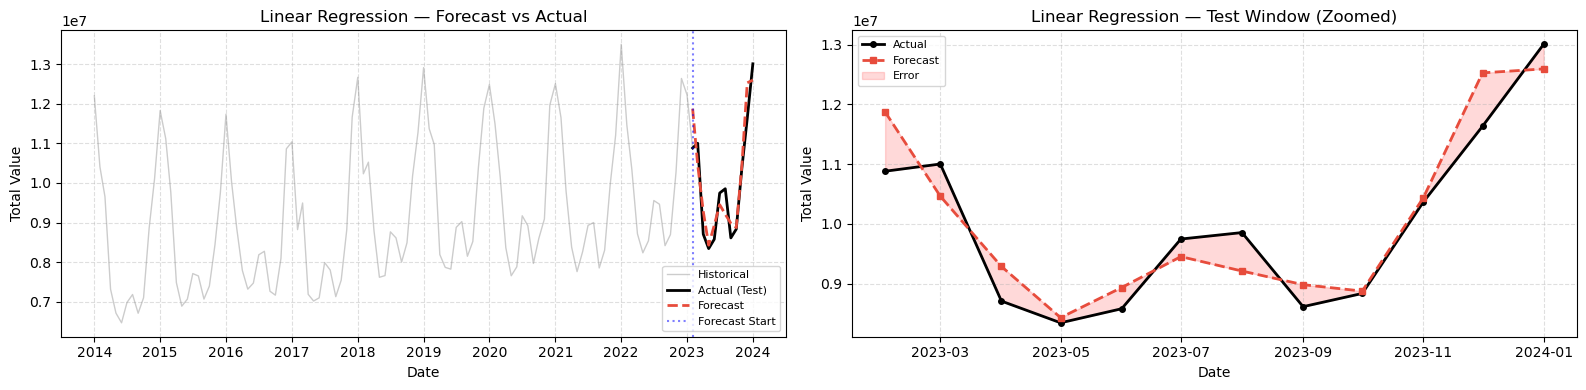

In [32]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_test_sc)
results.append(evaluate("Linear Regression", y_test, lr_pred))
plot_forecast("Linear Regression", y_test, lr_pred, test_dates)


#### Model 2: Ridge Regression

Ridge Regression                    | MAE=    432162.8 | RMSE=    513663.8 | R²=0.8646 | MAPE=4.23%


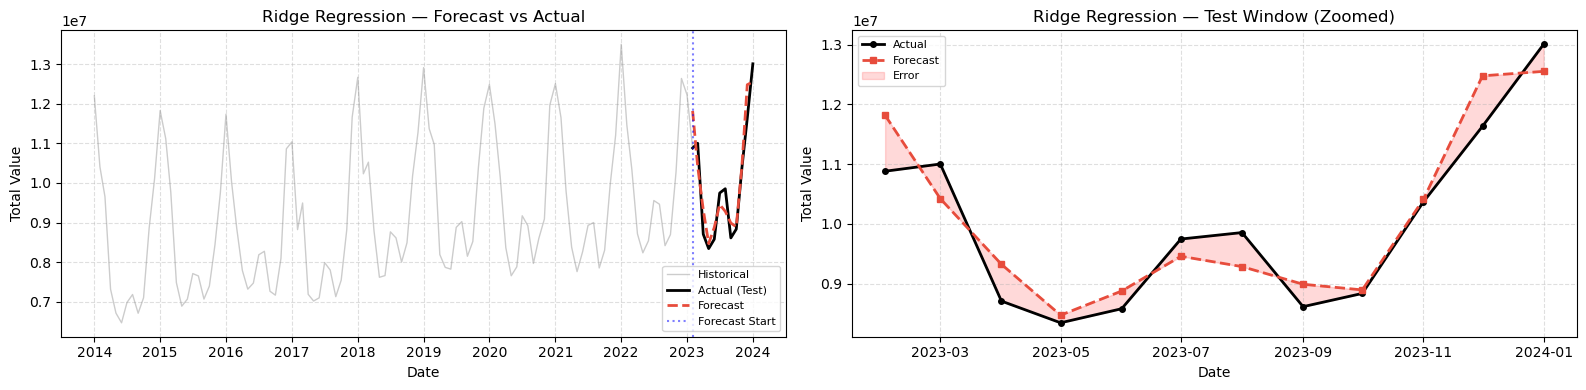

In [33]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sc, y_train)
ridge_pred = ridge.predict(X_test_sc)
results.append(evaluate("Ridge Regression", y_test, ridge_pred))
plot_forecast("Ridge Regression", y_test, ridge_pred, test_dates)


#### Model 3: Random Forest

Random Forest                       | MAE=    323489.5 | RMSE=    478332.2 | R²=0.8825 | MAPE=2.92%


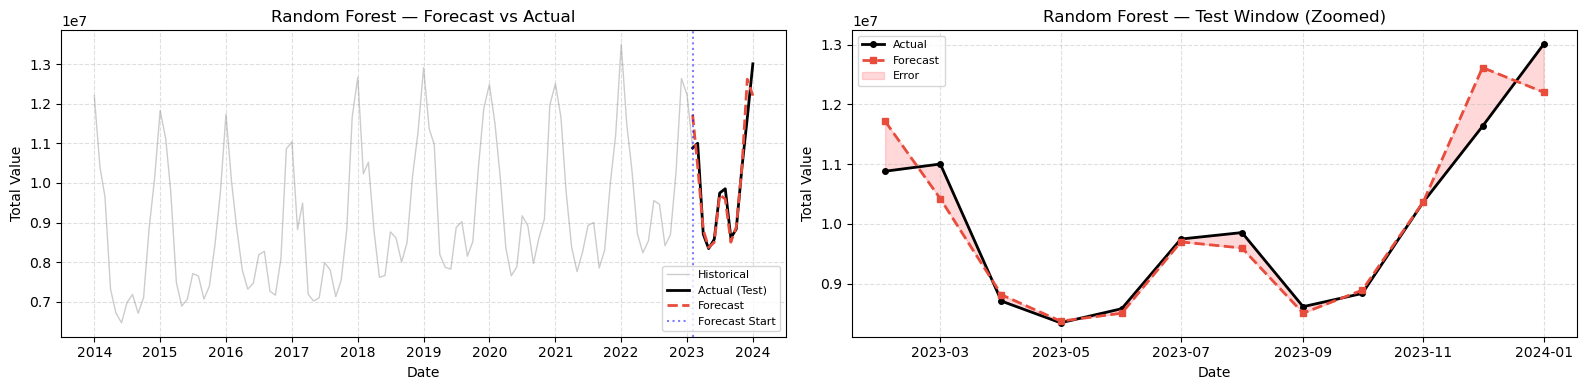

In [34]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results.append(evaluate("Random Forest", y_test, rf_pred))
plot_forecast("Random Forest", y_test, rf_pred, test_dates)


#### Model 4: XGBoost

XGBoost                             | MAE=    335231.6 | RMSE=    448145.8 | R²=0.8969 | MAPE=3.08%


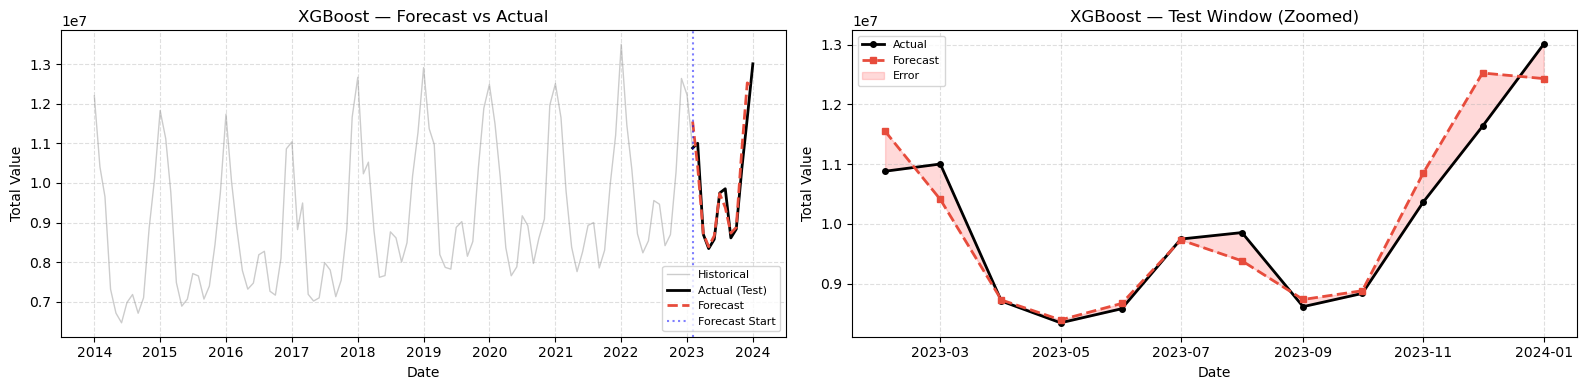

In [35]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
results.append(evaluate("XGBoost", y_test, xgb_pred))
plot_forecast("XGBoost", y_test, xgb_pred, test_dates)


#### Model 5: LightGBM

LightGBM                            | MAE=    321519.7 | RMSE=    491168.5 | R²=0.8762 | MAPE=2.97%


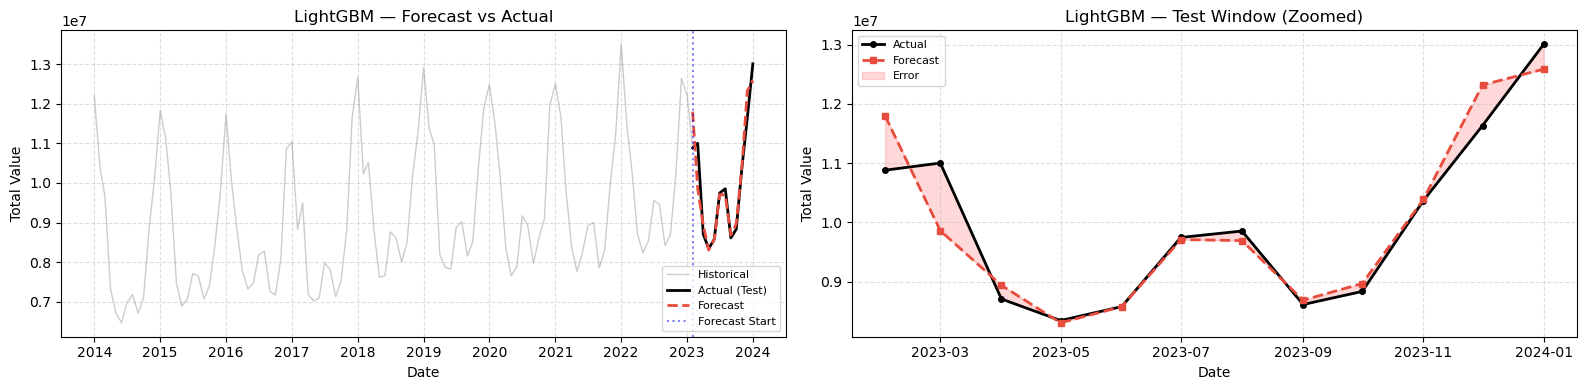

In [36]:
lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
results.append(evaluate("LightGBM", y_test, lgbm_pred))
plot_forecast("LightGBM", y_test, lgbm_pred, test_dates)


#### Model 6: Exponential Smoothing (ETS / Holt-Winters)

ETS (Holt-Winters)                  | MAE=    302055.5 | RMSE=    367079.3 | R²=0.9308 | MAPE=2.93%


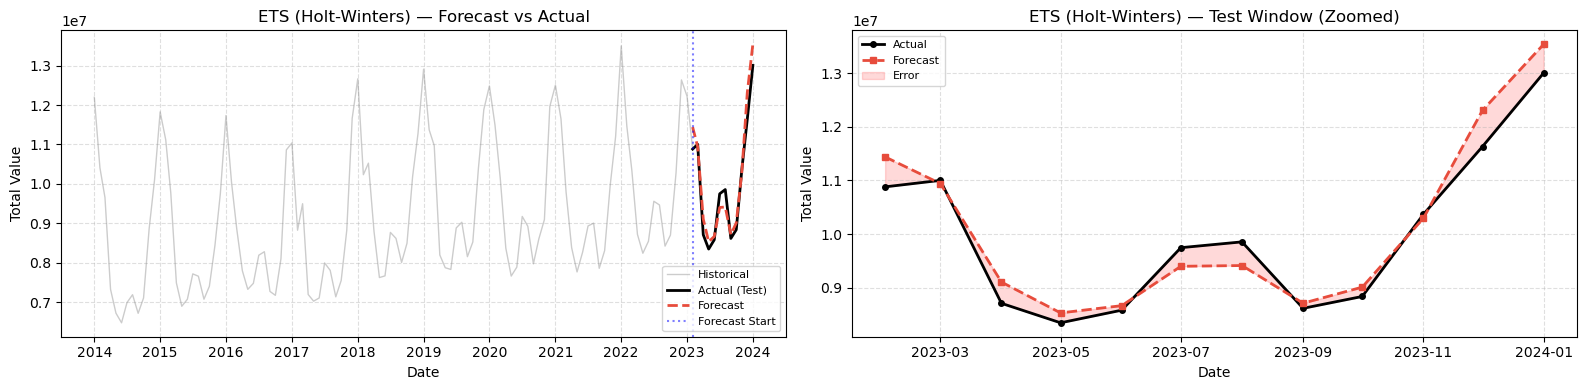

In [37]:
ets_model = ExponentialSmoothing(
    train_ts,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)

ets_pred = ets_model.forecast(TEST_MONTHS)
results.append(evaluate("ETS (Holt-Winters)", test_ts, ets_pred))
plot_forecast("ETS (Holt-Winters)", test_ts.values, ets_pred.values, test_dates)


#### Model 7: SARIMA

SARIMA(1,1,1)(1,1,1,12)             | MAE=    292982.9 | RMSE=    441158.3 | R²=0.9001 | MAPE=2.74%


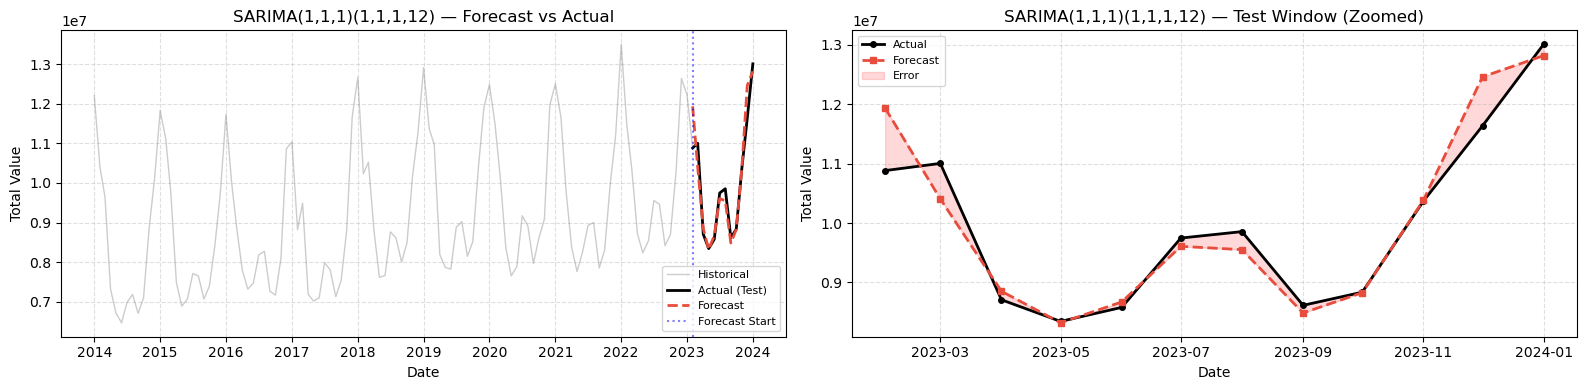

In [38]:
sarima_model = SARIMAX(
    train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_pred = sarima_model.forecast(TEST_MONTHS)
results.append(evaluate("SARIMA(1,1,1)(1,1,1,12)", test_ts, sarima_pred))
plot_forecast("SARIMA(1,1,1)(1,1,1,12)", test_ts.values, sarima_pred.values, test_dates)


#### Model Comparison

In [39]:
results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
print("\n=== Model Leaderboard (sorted by RMSE) ===\n")
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")


=== Model Leaderboard (sorted by RMSE) ===

                  Model           MAE          RMSE       R2     MAPE
     ETS (Holt-Winters) 302055.505061 367079.330999 0.930829 2.930117
SARIMA(1,1,1)(1,1,1,12) 292982.891837 441158.334006 0.900093 2.739047
                XGBoost 335231.583333 448145.842364 0.896903 3.082609
          Random Forest 323489.457083 478332.234626 0.882546 2.917507
               LightGBM 321519.662545 491168.478068 0.876158 2.967178
       Ridge Regression 432162.792811 513663.825094 0.864554 4.234959
      Linear Regression 439440.987479 528703.889226 0.856507 4.302964

Best Model: ETS (Holt-Winters)


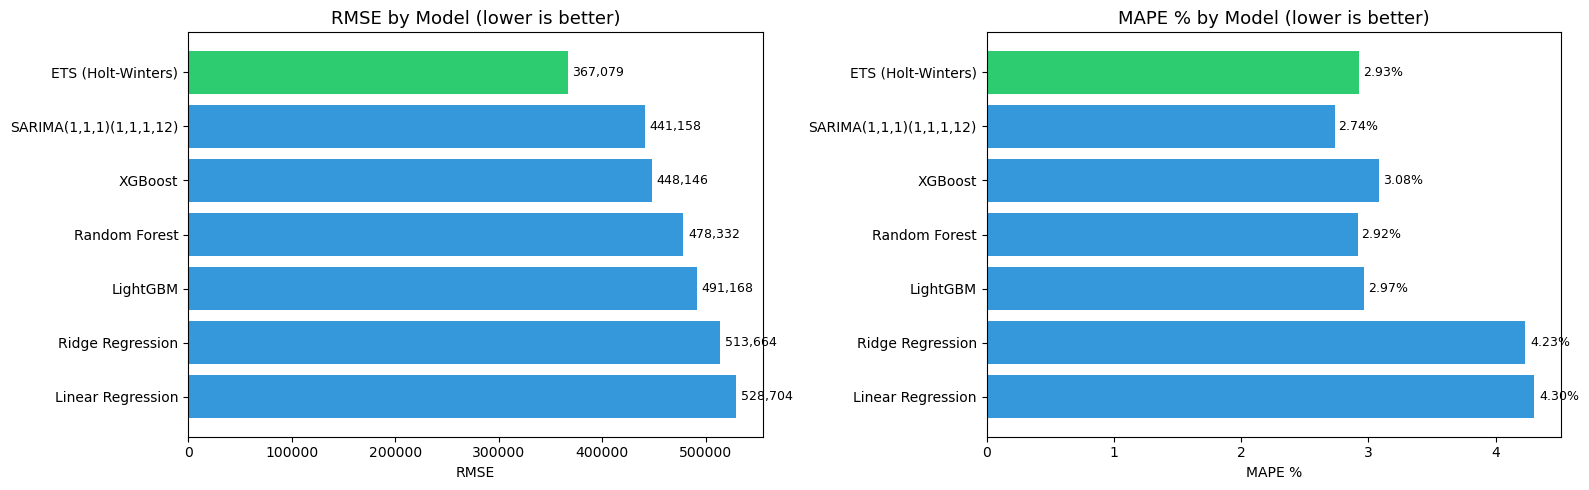

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))


colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
axes[0].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[0].set_title('RMSE by Model (lower is better)', fontsize=13)
axes[0].set_xlabel('RMSE')
axes[0].invert_yaxis()
for i, v in enumerate(results_df['RMSE']):
    axes[0].text(v * 1.01, i, f'{v:,.0f}', va='center', fontsize=9)

axes[1].barh(results_df['Model'], results_df['MAPE'], color=colors)
axes[1].set_title('MAPE % by Model (lower is better)', fontsize=13)
axes[1].set_xlabel('MAPE %')
axes[1].invert_yaxis()
for i, v in enumerate(results_df['MAPE']):
    axes[1].text(v * 1.01, i, f'{v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

#### Forecast vs Actual — Best Model

=== Best Model: ETS (Holt-Winters) ===


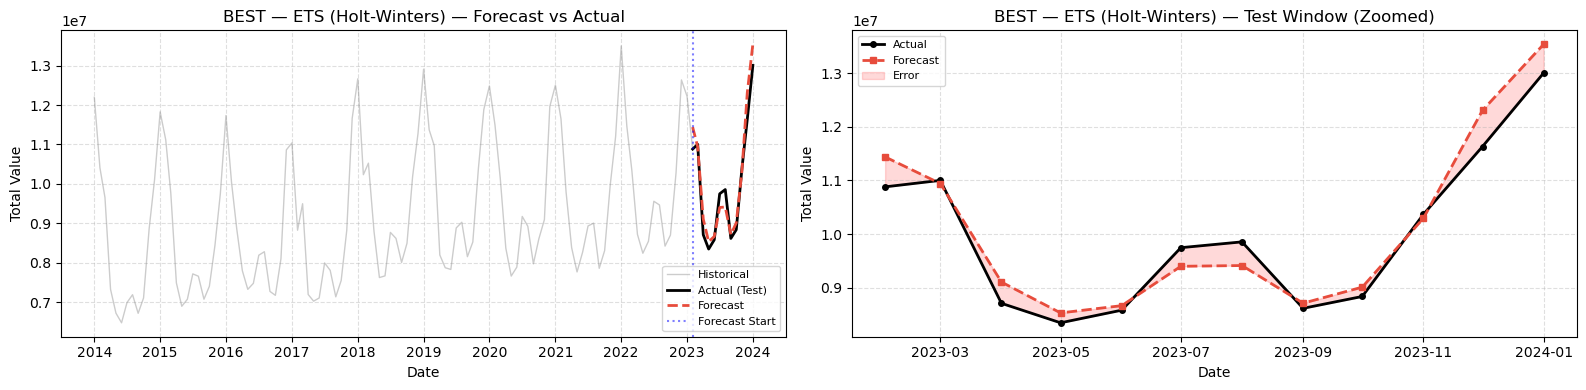

In [41]:
all_preds = {
    "Linear Regression":         lr_pred,
    "Ridge Regression":          ridge_pred,
    "Random Forest":             rf_pred,
    "XGBoost":                   xgb_pred,
    "LightGBM":                  lgbm_pred,
    "ETS (Holt-Winters)":        ets_pred.values,
    "SARIMA(1,1,1)(1,1,1,12)":   sarima_pred.values,
}

best_pred = all_preds[best_model_name]

print(f"=== Best Model: {best_model_name} ===")
plot_forecast(f"BEST — {best_model_name}", test_ts.values, best_pred, test_dates)


#### Forecasting using the model

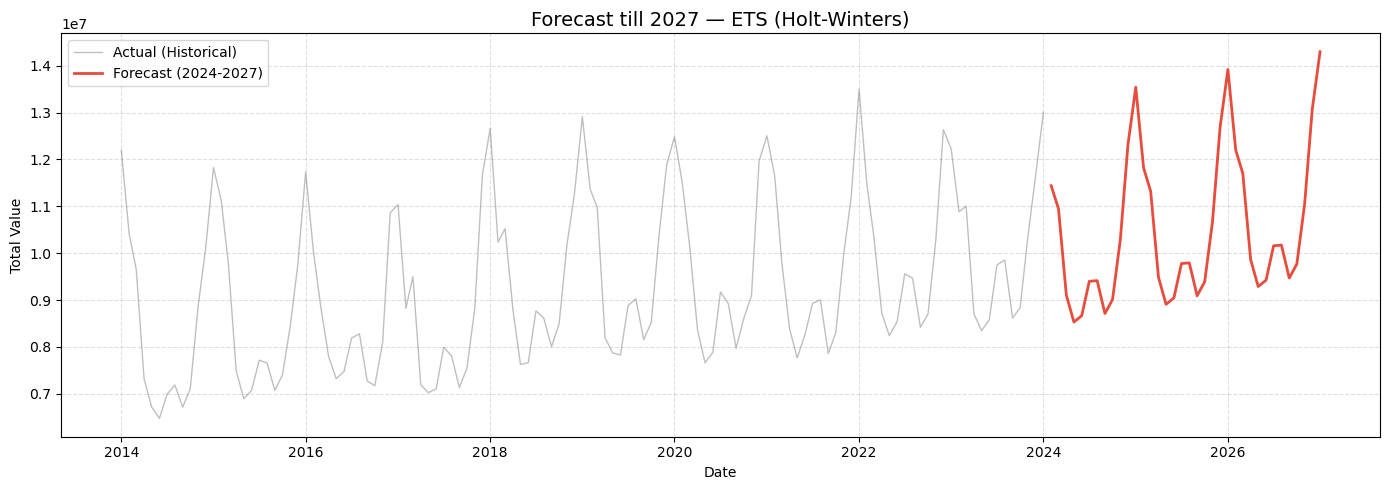

In [42]:
last_date = df_agg['ds'].max()
future_months = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2027-01-01', freq='MS')
future_df = pd.DataFrame({'ds': future_months})
full_df = pd.concat([df_agg[['ds', 'y']], future_df], ignore_index=True)
full_feat = create_features(full_df)
full_feat = full_feat.reset_index(drop=True)
future_feat = full_feat.loc[full_feat['ds'].isin(future_months)]
future_X = future_feat[feature_cols]

model_map = {
    "Linear Regression": (lr, scaler),
    "Ridge Regression": (ridge, scaler),
    "Random Forest": (rf, None),
    "XGBoost": (xgb, None),
    "LightGBM": (lgbm, None),
    "ETS (Holt-Winters)": (ets_model, None),
    "SARIMA(1,1,1)(1,1,1,12)": (sarima_model, None),
}
model, scaler_obj = model_map[best_model_name]
if scaler_obj:
    future_X_sc = scaler_obj.transform(future_X)
    future_pred = model.predict(future_X_sc)
elif best_model_name == "ETS (Holt-Winters)":
    n_periods = len(future_months)
    future_pred = ets_model.forecast(n_periods)
elif best_model_name == "SARIMA(1,1,1)(1,1,1,12)":
    n_periods = len(future_months)
    future_pred = sarima_model.forecast(n_periods)
else:
    future_pred = model.predict(future_X)

plt.figure(figsize=(14, 5))
plt.plot(df_agg['ds'], df_agg['y'], label='Actual (Historical)', color='gray', linewidth=1, alpha=0.5)
plt.plot(future_months, future_pred, label='Forecast (2024-2027)', color='#e74c3c', linewidth=2)
plt.title(f'Forecast till 2027 — {best_model_name}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('forecast_till_2027.png')
plt.show()


In [43]:
import joblib
joblib.dump(best_model_name, f"{best_model_name.replace(' ', '_')}_model.joblib")
if scaler_obj:
    joblib.dump(scaler_obj, f"{best_model_name.replace(' ', '_')}_scaler.joblib")